<a href="https://colab.research.google.com/github/eihwood/ML-Lab/blob/main/DL_in_Pytorch_Crash_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

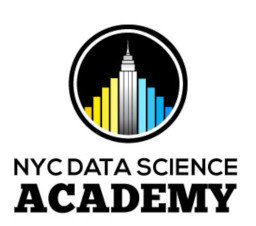

Welcome to NYC Data Science Academy Crash Course.

NYC Data Science Academy’s mission is to provide accelerated data science training programs that prepare people for employment as data science professionals and to offer continuing education courses for professional development. We have trained thousands of data science professioals and assisted them to land a job in the field. Check out our job outcomes from https://nycdatascience.com/our-outcome/

## Introduction
This is meant to be a fast paced introduction to machine learning using Pytorch. The goal is to get familiar with the basic aspects of building a model and train it on a supervised learning task.

In [ ]:
import torch

## Tensors

[Tensors](https://pytorch.org/docs/stable/tensors.html) are (multidimensional) arrays, and are the core data type used in deep learning.

In [ ]:
# create a new tensor out of existing data
t = torch.tensor([1,3,3,7])
print(t)
# get the the dimensions of a tensor
print(t.size())
# initialize a tensor of all ones of a particular size
t = torch.ones(2, 3, 4)
print(t)
# `torch.Size` can be unpacked
depth, height, width = t.size()
print('depth:', depth, 'height:', height, 'width:', width)
# tensors can be addressed just like numpy arrays
print(t[0].size())
# random, normally distributed tensors of a given size are also easy
t = torch.randn(2,3)
print(t)

tensor([1, 3, 3, 7])
torch.Size([4])
tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
depth: 2 height: 3 width: 4
torch.Size([3, 4])
tensor([[ 0.0727, -0.5302,  2.2051],
        [-0.0480, -0.2511, -0.9623]])


## Modules

Torch uses [Modules](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) as the brimary building block for models. A `Module` can represent a layer or an entire model (models can be used as layers within other models).

[torch.nn](https://pytorch.org/docs/stable/nn.html) is the primary library defining the most comong building blocks for most neural networks.

In [ ]:
# all basic layers/modules are defined in torch.nn
import torch.nn as nn

# a `Linear` layer (also called fully connected, or `Dense` in Keras)
# is just y = Wx + b. `Linear` takes the input dimension, output dimensions
# whether or not to include a bias term (default True)
m = nn.Linear(2, 3)
print(m)
print('weight matrix:', m.weight.size())
print('bias vector', m.bias.size())
# you can create one without a bias as well
m = nn.Linear(2, 3, bias=False)
print(m)
print('weight matrix:', m.weight.size())
print('bias vector', m.bias)

Linear(in_features=2, out_features=3, bias=True)
weight matrix: torch.Size([3, 2])
bias vector torch.Size([3])
Linear(in_features=2, out_features=3, bias=False)
weight matrix: torch.Size([3, 2])
bias vector None


## Simple Model: Multilayer Perceptron

We'll define a simple multilayer perceptron ([MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) a.k.a. feedforward network) with one hidden layer. This will be a subclass of `torch.nn.Module`, which requires:
* `__init__` with a call to `super().__init__()`
* `forward()` which defines how to run the model given an input

We will use the container [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) to glue all of our layers into a single module that passes the output from the previous step as the input to the next. Note that you must ensure that the output dimensions of the previous layer match the input dimensions of the next.

The main component which makes neural networks able to learn non-linear functions are the [activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) places between the various layers. Since this model is very small and simple, we will be using [torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid), which produces an "S curve" that squashes all values to the range 0.0 - 1.0.

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.Sigmoid(),
        nn.Linear(self.hidden_dim, self.output_dim),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    # the `Sequential` can just be called on the input
    return self.fc(x)

## Device

Torch supports multiple backends, most notibly `'cpu'` and `'cuda'` (with experimental support for Apple Metal as well). The main thing to remember is that all `Module`s and `Tensor`s neeed to be on the same device when running, or else you will get an error. Also note that all everything initially begins on CPU when created (with the exception of models that were saved while on GPU, but let's ignore that for now).

In [ ]:
# get the device we are using and save it for later. change the runtime
# to GPU to see if print `cuda`
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# create a tensor and send it to our device
x = torch.randn(2,3, device=device)
print(x)
# you can also send things to a device after they are creates
x = torch.randn(2, 3)
print(x)
x = x.to(device)
print(x)

# some operations, such as converting to a numpy array, require tensors
# to be on the CPU specifically, so using `.cpu()` is helpful
print(x.cpu().numpy())
# there is also `.cuda()` but that asumesthat you actually have a GPU

cpu


RuntimeError: ignored

## Dataset

The primary mechanisms for working with data live in [torch.utils.data](https://pytorch.org/docs/stable/data.html).

Now we will make a model that solves [XOR](https://en.wikipedia.org/wiki/Exclusive_or). This will require creating:
* a [map-style](https://pytorch.org/docs/stable/data.html#map-style-datasets) `Dataset` to hold our examples
* a model to train
* a training loop

Although simple, XOR is useful as it requires a model that can handle non-linear relationships between inputs and outputs: it is not possible to draw a single straight line as a decision boundary.

In [ ]:
'''
a `Dataset` is an interface for defining data to train on. it requires defining
* __init__
* __len__ to return the number of training examples
* __getitem__ to return an example at a specific index
'''
from torch.utils.data import Dataset

class XorDataset(Dataset):
  def __init__(self):
    # example inputs
    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        1,
        1,
        0
    ]
  
  def __len__(self):
    # return the number of training examples
    return len(self.x)
  
  def __getitem__(self, idx):
    # return the input/output for a given example (by index)
    x = self.x[idx]
    y = self.y[idx]
    return {'x': torch.FloatTensor(x), 'y': torch.FloatTensor([y])}

xor_dataset = XorDataset()
print(xor_dataset[2])

{'x': tensor([0., 1.]), 'y': tensor([1.])}


## DataLoader and Batching

The most common way to work with a `Dataset` is to use a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). This handles things like:
* iterating through the `Dataset`
* optionally randomizing the order of examples
* batching examples together

Batching (a.k.a. mini-batches) means loading multiple training examples in *parallel*. This is helpful, especially when using GPUs, for being able to do more computation in a single pass, speeding up traning for feedforward models. Additionally some objectives like contrastive learning specifically rely on batcfhing as part of the loss function. However recurrent models benefit less from batching as they take sequences as input, which often requires padding shorter examples since everything in the batch needs to be the same length.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

dataloader = DataLoader(xor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for batch in dataloader:
  x = batch['x']
  y = batch['y']
  print(x, 'x.size()', x.size())
  print(y, 'y.size()', y.size())

tensor([[0., 0.],
        [0., 1.],
        [1., 1.]]) x.size() torch.Size([3, 2])
tensor([[0.],
        [1.],
        [0.]]) y.size() torch.Size([3, 1])


## Training Setup

For supervised learning, we need:
* a model to train
* a dataset
* an [optimizer](https://pytorch.org/docs/stable/optim.html)
* an objective ([loss function](https://pytorch.org/docs/stable/nn.html#loss-functions))

We then loop over all of our training data multiple times (epochs) and track the loss so that we can see how the model is improving. Of course you can (and usually should) also track validation loss on your test data, but we will omit that here.

Here we will be using the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer and [mean squared error loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).

In [ ]:
from torch.optim import Adam
from tqdm import trange  # gives us a nice progress bar

epochs = 5000  # the number of times to iterate through the training data

model = MLP(2, 2, 1)  # create an instance of our model
model = model.to(device)  # send the model to the appropriate device
print(model.train())  # set the model to train mode (default) and print it for good measure
opt = Adam(model.parameters())  # initialize the optimizer with the model parameters
loss_fn = nn.MSELoss()  # create an instance of our loss function
losses = []  # create an empty list for tracking the loss every epoch

for epoch in trange(epochs):  # loop for the number of epochs
  for batch in dataloader:  # iterate through the dataset
  
    # get the inputs and target outputs and send them to the device
    x = batch['x'].to(device)
    y = batch['y'].to(device)

    # run the model and get its prediction
    y_hat = model(x)

    # calculate the loss
    loss = loss_fn(y_hat, y)

    # clear the previous gradient from the optimizer
    opt.zero_grad()
    # calculate the gradient based on the loss
    loss.backward()
    # update the model weights based on the gradient
    opt.step()

    '''
    Store the loss in a list so that we can plot it later.
    When doing so however, we need to call `.detach()` in
    order to remove the gradient, `.cpu()` to make sure it
    is on the CPU, and `.numpy()` to convert it into a numpy
    value because matplotlib doesn't work directly on tensors.
    '''
    losses.append(loss.detach().cpu().numpy())

MLP(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


100%|██████████| 5000/5000 [00:11<00:00, 418.19it/s]


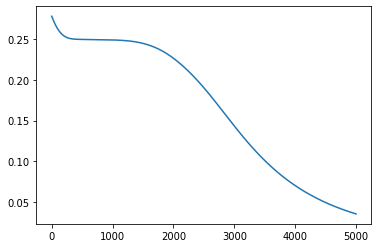

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

Since our training data is so small, we can iterate through all examples and compare the prediction to the target. For more complex datasets/tasks could use a test set to plot the validation loss, calculate a confusion matrix, etc.

In [ ]:
model = model.cpu()
model.eval()

with torch.no_grad():
  for example in xor_dataset:
    x = example['x']
    y = example['y']
    y_hat = model(x) 
    loss = loss_fn(y_hat, y)
    print('x:', x, 'y:', y, 'y_hat:', y_hat, 'loss:', loss)

x: tensor([0., 0.]) y: tensor([0.]) y_hat: tensor([0.1744]) loss: tensor(0.0304)
x: tensor([1., 0.]) y: tensor([1.]) y_hat: tensor([0.8192]) loss: tensor(0.0327)
x: tensor([0., 1.]) y: tensor([1.]) y_hat: tensor([0.8135]) loss: tensor(0.0348)
x: tensor([1., 1.]) y: tensor([0.]) y_hat: tensor([0.2047]) loss: tensor(0.0419)


## Bonus 1: Convolution Layer Overview

One of the most important early developments in deep learning was [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network). The basic idea is that you can sweep a small window (called a kernel) across an input in order to extract higher level features useful for downstream processing. 2D Convolution has been extremely important in computer vision, but the same exact approach works in 1D (e.g. time series), and 3D (either three spatial dimensions or 2D + time). Pytorch implements these in the [torch.nn library](https://pytorch.org/docs/stable/nn.html#convolution-layers) we saw earlier.

The idea is that you define a small patch of learnable weights that will be **shared** across all spatial locations of the input. This is opposed to a `Linear` (fully connected) layer which learns a single set of weights for the entire input. As a result, convolutions allow for learning *local* or *translationally invariant* features, whereas fully connected layers learn *global* features. This is helpful in vision because "a 7 is a 7 regardless of where in the image it appears." [Here](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) is a good overview of convolution in general.

Since convolutions learn to extract features from small patches, it is usually required to stack multiple layers in sequence in order to learn more complex features. One common architecture is called a Residual Network (ResNet for short) allows for stable training of very deep convolutionl networks. [Here](https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278) is good walkthrough of how to implement one Pytorch.

### Kernels

The learnable parameters of a convolution are its kernel. Specifically in the 2D (image) case, a kernel has four dimensions:
* the width of the patch
* the height of the patch
* the number of **input channels**
* the number of **output channels**
Beyond that, the convolution layer itself can optionally define things like `stride` (the number of steps to move by in the x/y dimension), `dilation` (the number of steps to skip **between** each row/column of the kernel), but for now we will ignore those.

Width and height are exactly what they sound like. Channels however are more abstract. For an input image, there are typically either one (for grayscale) or three (for color) channels. In intermediate layers the number of channels represents the number of unique feature maps the layer can represent. Typically this increases as you go deeper into the network. It is worth noting that the relationship between *input* and *output* channels is exactly the same as a `Linear` layer (see [1x1 convolutions](https://towardsdatascience.com/1x1-convolution-5219bbc09027/) for a more in-depth explanation).

In [ ]:
batch_size = 1
channels = 3  # red, green, blue
height = width = 28
x = torch.randn(batch_size, channels, height, width)
print('original input size:', x.size())

l = nn.Conv2d(channels, 16, 3, bias=False)  # 3x3 kernel, 3 input channels, 16 output channels
print(l.eval())
z = l(x)
# note that the channel dimension is now 16 and the width/height has reduced by 2
print('size after convolution', z.size())

original input size: torch.Size([1, 3, 28, 28])
Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
size after convolution torch.Size([1, 16, 26, 26])


## Bonus 2: Recurrent Layer Overview

So far we have seen `Linear` layers, which have a fixed input dimension, and convolution layers, which slide a fixed size window over their input. Both of these work on fixed-length inputs. While they can process larger inputs in the form of batches, each example is processed in parallel and no information can be shared between them. For some use cases, such as fixed size images or a known set of coumns in a record, this is perfectly fine. However when working with time series data (which includes text) we often do not know the input length ahead of time, or it is generally variable. While we can decide on some maximum sequence length and pad shorter inputs, it would be nice if we could take sequences of arbitrary length as an input directly. This is exactly what **Recurrent Neural Networks** (RNNs) are for.

RNNs work based on two inputs: the current sequence value and a *hidden state*. Hidden state is just a fancy name for memory, which is a vector that we use to store information from previous inputs. The basic pseudo code using an RNN is:

```python
h = torch.zeros(...)
for x in inputs:
  h = rnn(x, h)
# do something with h
```

The main advantage of RNNs is that they can (theoretically at lease) handle arbitrarily long sequences. In reality there is a practical limit to how much they can remember based on (at least) two major factors:

* vanishing/exploding gradients making it difficult to train on longer sequences (addressed by [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) and [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU/))
* the fact that the hidden state is a fixed size, only offering finite memory capacity

One other thing to keep in mind is that since RNNs process inputs sequentially they are inherently sequential and thus do not benefit nearly as much from GPUs (although they can still be trained on batches, provided all inputs are padded to be the same length).

A classic (yet dated) blog post by Andrej Karpathy is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Even though things have changed quite a lot since it was written, it is still a good overview of some of the uses for RNNs.

## Bonus 3: Transformers Overview

Since 2017, the deep learning world has been taken by storm with the advent of the Transformer. First proposed in the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) by researchers at Google Brain (but really in [Using Fast Weights to Attend to the Recent Past](https://arxiv.org/abs/1610.06258), and really really in [1991 by Jürgen Schmidhuber](https://people.idsia.ch/~juergen/fast-weight-programmer-1991-transformer.html)), the Transformer has basically become state of the art in most things. Most notibly with models like [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), the [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer) series, Vision Transformer ([ViT](https://arxiv.org/abs/2010.11929)), among others.

The main thing to know about transformers is that they operate on **sets**. Often you hear about them being used on sequences, which requires applying [positional encoding](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/) to the input. They also have a **fixed** input size, making them less flexible compared to RNNs, however due to the attention mechanism they are able to pass information between *any* part of the input to any other part, rather than being forced to only propegate information forward through the sequence.

## Bonus 4: Other Resources

* [Andrej Karpathy](https://www.youtube.com/@AndrejKarpathy)'s Youtube Channel where he is currently building a minimal implementation of Pytorch from the ground up
* [Yannic Kilcher](https://www.youtube.com/@YannicKilcher)'s Youtube channel where he has overviews of tons of papers, streams working on open source projects, and keeps up with current events in ML
* [lucidrains](https://github.com/lucidrains) on github who implements absolutely everything